# Power Analysis for Adjusters

Consider two e-processes for testing randomness: $\mathfrak{e}_t$, which is valid in the data filtration $\mathbb{F}$, and $\mathfrak{e}_t'$, which is only valid in a sub-filtration $\mathbb{G} \subsetneq \mathbb{F}$. To combine these two e-processses, we need to adjust $\mathfrak{e}_t'$ to the data filtration $\mathbb{F}$.

Here, we combine the difference in "statistical power" between:
1. the combined e-process obtained via adjustment, i.e., $\bar{\mathfrak{e}}_t = \frac{1}{2}[\mathfrak{e}_t + A((\mathfrak{e}_t')^*)]$
2. the simple average without adjustment (_invalid_ in $\mathbb{F}$), i.e., $M_t = \frac{1}{2}[\mathfrak{e}_t + \mathfrak{e}_t']$.


Two notions of statistical power are considered:
1. **Power of a test**: given the induced sequential test $\phi_t = 1(\mathfrak{e}_t \geq 1/\alpha)$, compute $$Q(\phi_t = 1).$$
2. **E-Power**: compute $$\mathbb{E}_Q[\log \mathfrak{e}_t].$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import os
from tqdm.notebook import trange

import ecombine as ec

In [2]:
# basic figure styles
ec.set_theme()

# rng for (randomized) inference methods
rng = np.random.default_rng(30105202)
# rng seed for data generator
rng_data_seed = 20250103

# Adjuster type (important for power!)
# adjuster_type, adjuster_kwargs = "default", dict(use_maximum=True, use_zero=False, kappa=None)  # default: mixture of (no zero) adjusters
adjuster_type, adjuster_kwargs = "zero", dict(use_maximum=True, use_zero=True, kappa=1.0)  # zero adjuster
# adjuster_type, adjuster_kwargs = "kappa25", dict(use_maximum=True, use_zero=False, kappa=.25)  # no zero adjuster, growth rate 3/4 of max

# plots saved here
plots_dir = "./plots/exch/power_analysis" + ("" if adjuster_type == "default" else f"_{adjuster_type}")
plot_fmt = "pdf"
os.makedirs(plots_dir, exist_ok=True)
mpl.rc("savefig", format=plot_fmt, dpi=350)

### Setup: Combining UI & Conformal under a Changepoint Alternative

In [3]:
# number of repeated trials
N_TRIALS = 100

# max sequence length
T = 2000

# significance level
ALPHA = 0.1

# change sizes (q = p + change_size)
BASE_P = 0.3
CHANGE_SIZES = (0.0, 0.1, 0.2, 0.3, 0.4)
CHANGE_EVERY = 100

# data rng
rng_data = np.random.default_rng(rng_data_seed)

In [4]:
# conformal hyperparams
jump = 0.01
jumper_weights = (1/3, 1/3, 1/3)
# jumper_weights = (0.5, 0.0, 0.5)

### A Changepoint Alternative (one "shock")

Conformal test martingales grow quickly against changepoint alternatives.

The following data repeatedly changes from $Ber(p)$ to $Ber(q)$ and vice versa every `change_every` steps.

In [5]:
p, q = BASE_P, BASE_P + CHANGE_SIZES[-1]
x_change_rep = ec.data.exch.generate_binary_change_repeated(
    p=p, q=q, size=T, change_every=CHANGE_EVERY, rng=rng_data
)
x_change_rep

array([0, 1, 0, ..., 1, 1, 0])

### A Markovian alternative

Universal inference e-processes grow quickly against Markovian alternatives.

The following data is generated from a first-order Markov chain with transition probabilities $p_{10}$ and $p_{11}$.

In [6]:
p_10, p_11 = p, q
x_markov = ec.data.exch.generate_binary_markov(
    p_10=p_10, p_11=p_11, size=T, rng=rng_data
)
x_markov

array([0, 1, 1, ..., 1, 1, 0])

### Power of the induced test and E-Power

In [7]:
def run_power_experiment(
        n_trials,
        change_sizes=CHANGE_SIZES,
        alpha=ALPHA,  # significance level
        alternative="Changepoint",  # "markovian" or "changepoint"
        change_every=CHANGE_EVERY,  # changepoint frequency
        combined=True,  # combine UI and conformal
        **conformal_kwargs
):
    """Run power experiment over repeated simulations."""

    full_df = []  # one df per run, combine at the end
    for change_size in change_sizes:
        p = BASE_P
        q = p + change_size
        # p = 0.5 - change_size / 2
        # q = 0.5 + change_size / 2
        for i in trange(n_trials, desc=f"Change size {change_size}"):
            # Generate data
            if alternative == "Changepoint":
                data = ec.data.exch.generate_binary_change_repeated(
                    p=p, q=q, size=T, change_every=change_every, rng=rng_data
                )
            elif alternative == "Markovian":
                data = ec.data.exch.generate_binary_markov(
                    p_10=p, p_11=q, size=T, rng=rng_data
                )
            else:
                raise ValueError("Unknown alternative: choose either 'Changepoint' or 'Markovian'.")

            # Compute UI e-process
            ui_eprocess = ec.eprocess_exch_universal(data)
            
            # Compute unadjusted conformal e-process
            conf_eprocess = ec.eprocess_exch_conformal(data, **conformal_kwargs)

            # Adjusted conformal
            adj_conf_eprocess = ec.adjuster(conf_eprocess, **adjuster_kwargs)

            # Combine UI and conformal
            if combined:
                unadj_eprocess = 0.5 * (ui_eprocess + conf_eprocess)
                adj_eprocess = 0.5 * (ui_eprocess + adj_conf_eprocess)
            else:
                unadj_eprocess = conf_eprocess if alternative == "Changepoint" else ui_eprocess
                adj_eprocess = adj_conf_eprocess if alternative == "Changepoint" else ui_eprocess

            # # Compute the rejection of a test at level alpha
            # power = np.maximum.accumulate(eprocess) >= (1 / alpha)
            # # Compute e-power
            # epower = np.log(eprocess)

            # Add as df
            times = np.arange(1, T + 1)
            full_df.append(pd.DataFrame({
                "Alternative": alternative,
                "ChangeSize": change_size,
                "RunID": i, 
                "Time": times,
                "Data": data,
                "Unadjusted": unadj_eprocess,
                "Adjusted": adj_eprocess,
                "UnadjustedPower": np.maximum.accumulate(unadj_eprocess) >= (1 / alpha),
                "AdjustedPower": np.maximum.accumulate(adj_eprocess) >= (1 / alpha),
                "UnadjustedEPower": np.log(np.maximum(ec.EPS, unadj_eprocess)),
                "AdjustedEPower": np.log(np.maximum(ec.EPS, adj_eprocess)),
            }))
        # Aggregate all experiment results
    full_df = pd.concat(full_df, axis=0)
    return full_df

In [8]:
conformal_kwargs = dict(
    jump=jump,
    jumper_weights=jumper_weights,
    rng=rng,
)

df_path = os.path.join(plots_dir, "PowerExperimentResults.csv")
if os.path.exists(df_path):
    full_df = pd.read_csv(df_path)
else:
    change_df = run_power_experiment(
        n_trials=N_TRIALS,
        change_sizes=CHANGE_SIZES,
        alpha=ALPHA,
        alternative="Changepoint",
        change_every=CHANGE_EVERY,
        **conformal_kwargs
    )
    markov_df = run_power_experiment(
        n_trials=N_TRIALS,
        change_sizes=CHANGE_SIZES,
        alpha=ALPHA,
        alternative="Markovian",
        **conformal_kwargs
    )
    full_df = pd.concat([change_df, markov_df], axis=0)
    full_df.to_csv(df_path, index=False)

full_df

,Alternative,ChangeSize,RunID,Time,Data,Unadjusted,Adjusted,UnadjustedPower,AdjustedPower,UnadjustedEPower,AdjustedEPower
0,Changepoint,0.0,0,1,1,1.000000e+00,5.000000e-01,False,False,0.000000,-0.693147
1,Changepoint,0.0,0,2,0,6.250000e-01,1.250000e-01,False,False,-0.470004,-2.079442
2,Changepoint,0.0,0,3,1,6.001099e-01,1.250000e-01,False,False,-0.510643,-2.079442
3,Changepoint,0.0,0,4,0,7.125533e-01,2.373047e-01,False,False,-0.338901,-1.438410
4,Changepoint,0.0,0,5,0,5.902394e-01,1.111111e-01,False,False,-0.527227,-2.197225
...,...,...,...,...,...,...,...,...,...,...,...
1999995,Markovian,0.4,99,1996,0,2.211693e+65,2.211693e+65,True,True,150.461789,150.461789
1999996,Markovian,0.4,99,1997,0,3.092334e+65,3.092334e+65,True,True,150.796957,150.796957
1999997,Markovian,0.4,99,1998,0,4.323344e+65,4.323344e+65,True,True,151.132060,151.132060
1999998,Markovian,0.4,99,1999,0,6.044008e+65,6.044008e+65,True,True,151.467098,151.467098


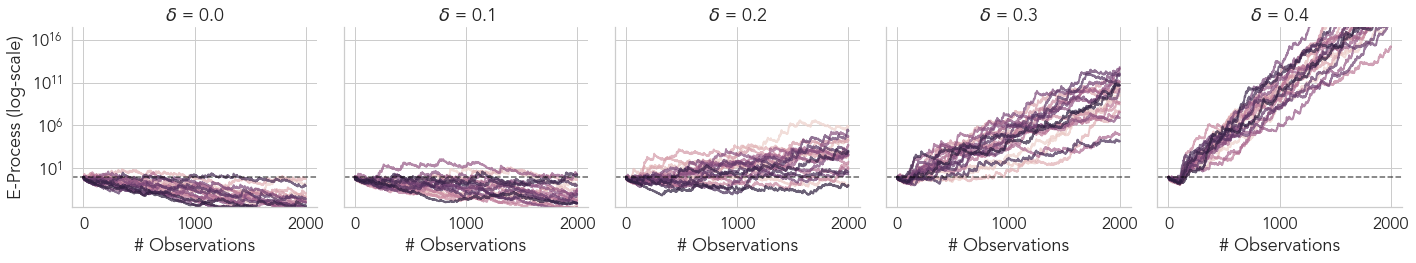

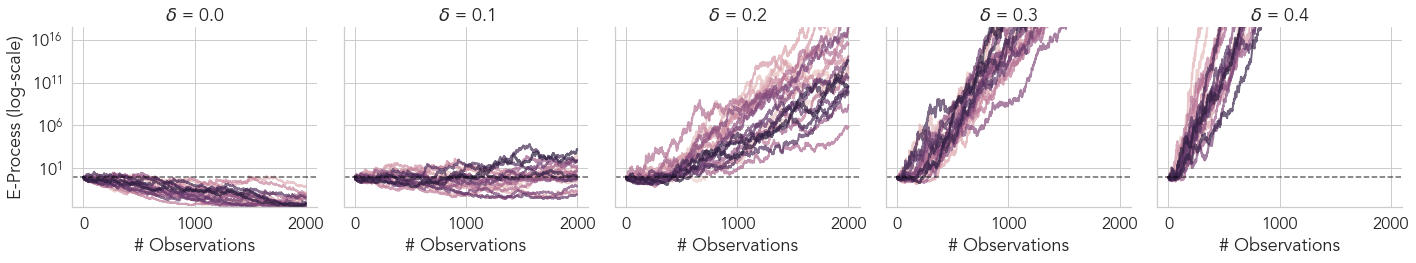

In [9]:
# Plot the first K e-processes per alternative
for alternative in ["Changepoint", "Markovian"]:
    fg = sns.relplot(
        data=full_df.loc[(full_df["RunID"] <= 20) & (full_df["Alternative"] == alternative)],
        x="Time",
        y="Unadjusted",
        col="ChangeSize",
        kind="line",
        hue="RunID",
        aspect=1,
        height=4,
        linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
        alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
        legend=None,
    )
    fg.set_titles(r"$\delta$" + " = {col_name}")
    for ax in fg.axes.flatten():
        ax.set(
            xlabel="# Observations",
            ylabel="E-Process (log-scale)",
            yscale="log",
            ylim=(10 ** -3.5, 10 ** 17.5)
        )
        ax.axhline(y=1, color="black", alpha=0.6, linestyle="dashed")
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, f"EProcessesSample{alternative}.pdf"), bbox_inches="tight")
    fg.savefig(os.path.join(plots_dir, f"EProcessesSample{alternative}.png"), dpi=350, bbox_inches="tight")
    None

### vs. # Observations

In [10]:
LABELS = {
    "Unadjusted": "Simple Mean",
    "Adjusted": "Adjust-Then-Combine",
}
LABEL_ORDER = ["Adjust-Then-Combine", "Simple Mean"]

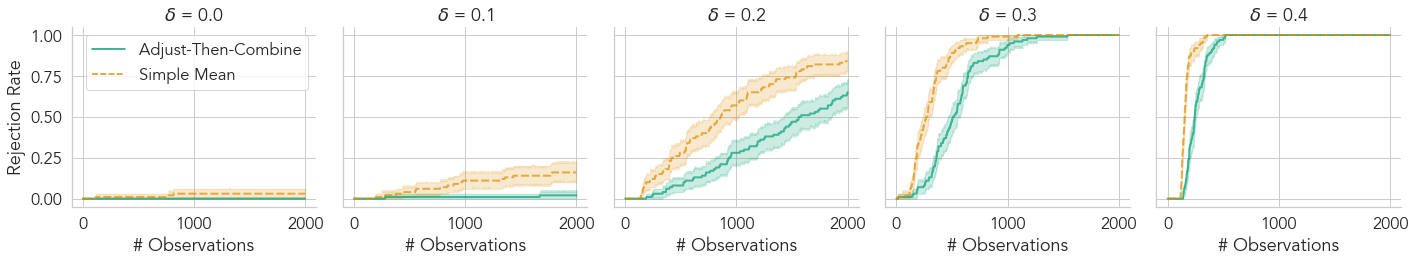

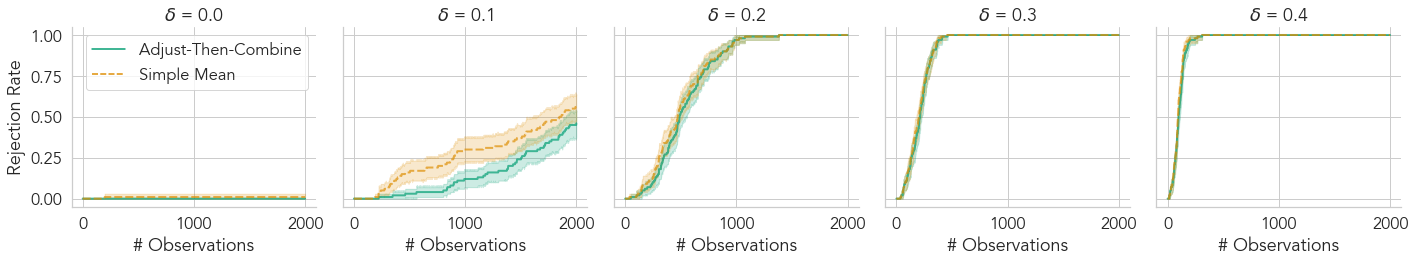

In [11]:
# Power
for alternative in ["Changepoint", "Markovian"]:
    power_df = full_df.loc[full_df["Alternative"] == alternative].melt(
        id_vars=["RunID", "Time", "ChangeSize"], value_vars=["UnadjustedPower", "AdjustedPower"],
        var_name="E-Process", value_name="Power")
    power_df["E-Process"] = power_df["E-Process"].map(
        {"UnadjustedPower": LABELS["Unadjusted"], "AdjustedPower": LABELS["Adjusted"]})
    fg = sns.relplot(
        x="Time",
        y="Power",
        col="ChangeSize",
        hue="E-Process",
        hue_order=LABEL_ORDER,
        palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
        style="E-Process",
        style_order=LABEL_ORDER,
        kind="line",
        # markers=True,
        errorbar=("ci", 100 * (1 - ALPHA)),
        aspect=1,
        height=4,
        linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
        alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
        data=power_df,
        facet_kws=dict(legend_out=False),
    )
    fg._legend.set_title(None)
    fg.set_titles(r"$\delta$" + " = {col_name}")
    for ax in fg.axes.flatten():
        ax.set(
            ylim=(-0.05, 1.05),
            ylabel="Rejection Rate",
            xlabel="# Observations",
        )
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, f"PowerVsSampleSize{alternative}.pdf"), bbox_inches="tight")
    fg.savefig(os.path.join(plots_dir, f"PowerVsSampleSize{alternative}.png"), dpi=350, bbox_inches="tight")
    None

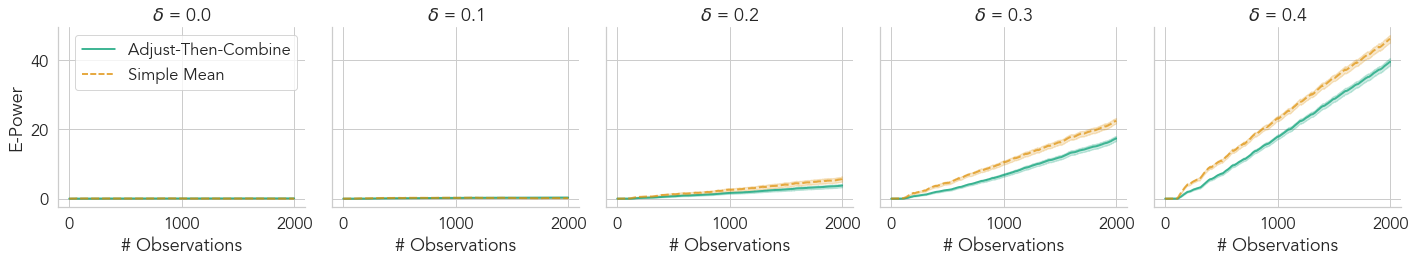

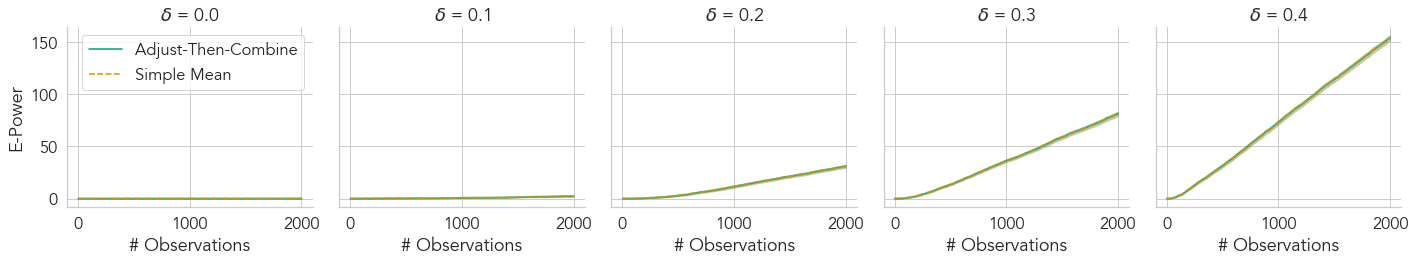

In [12]:
# E-Power
for alternative in ["Changepoint", "Markovian"]:
    epower_df = full_df.loc[full_df["Alternative"] == alternative].melt(
        id_vars=["RunID", "Time", "ChangeSize"], value_vars=["UnadjustedEPower", "AdjustedEPower"],
        var_name="E-Process", value_name="E-Power")
    epower_df["E-Process"] = epower_df["E-Process"].map(
        {"UnadjustedEPower": LABELS["Unadjusted"], "AdjustedEPower": LABELS["Adjusted"]})
    # clip e-power at zero
    epower_df["E-Power"] = np.maximum(0, epower_df["E-Power"])
    fg = sns.relplot(
        x="Time",
        y="E-Power",
        col="ChangeSize",
        hue="E-Process",
        hue_order=LABEL_ORDER,
        palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
        style="E-Process",
        style_order=LABEL_ORDER,
        kind="line",
        # markers=True,
        errorbar=("ci", 100 * (1 - ALPHA)),
        aspect=1,
        height=4,
        linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
        alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
        data=epower_df,
        facet_kws=dict(legend_out=False),
    )
    fg._legend.set_title(None)
    fg.set_titles(r"$\delta$" + " = {col_name}")
    for ax in fg.axes.flatten():
        ax.set(
            ylabel="E-Power",
            xlabel="# Observations",
        )
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, f"EPowerVsSampleSize{alternative}.pdf"), bbox_inches="tight")
    fg.savefig(os.path.join(plots_dir, f"EPowerVsSampleSize{alternative}.png"), dpi=350, bbox_inches="tight")
    None

### vs. Change Size

We "collapse" the sample size dimension by looking at whether a test was rejected within the 1000 steps.


In [13]:
idf = full_df.query(f"ChangeSize == {CHANGE_SIZES[2]} and RunID == 0")
idf

,Alternative,ChangeSize,RunID,Time,Data,Unadjusted,Adjusted,UnadjustedPower,AdjustedPower,UnadjustedEPower,AdjustedEPower
400000,Changepoint,0.2,0,1,0,1.000000e+00,5.000000e-01,False,False,0.000000,-0.693147
400001,Changepoint,0.2,0,2,1,6.250000e-01,1.250000e-01,False,False,-0.470004,-2.079442
400002,Changepoint,0.2,0,3,0,5.870324e-01,1.250000e-01,False,False,-0.532675,-2.079442
400003,Changepoint,0.2,0,4,0,5.382620e-01,4.687500e-02,False,False,-0.619410,-3.060271
400004,Changepoint,0.2,0,5,0,5.877333e-01,3.125000e-02,False,False,-0.531482,-3.465736
...,...,...,...,...,...,...,...,...,...,...,...
1401995,Markovian,0.2,0,1996,0,1.813515e+12,1.813515e+12,True,True,28.226288,28.226288
1401996,Markovian,0.2,0,1997,1,1.461789e+12,1.461789e+12,True,True,28.010682,28.010682
1401997,Markovian,0.2,0,1998,1,1.917218e+12,1.917218e+12,True,True,28.281896,28.281896
1401998,Markovian,0.2,0,1999,0,1.547324e+12,1.547324e+12,True,True,28.067548,28.067548


In [14]:
# Compute rejection times and max e-values
collapsed_df = []
for alternative in ["Changepoint", "Markovian"]:
    cdf = []
    for change_size in full_df.ChangeSize.unique():
        for run_id in full_df.RunID.unique():
            # idf = full_df.query(f"ChangeSize == {change_size} and RunID == {run_id}")
            idf = full_df.loc[
                (full_df["Alternative"] == alternative) &
                (full_df["ChangeSize"] == change_size) & 
                (full_df["RunID"] == run_id)
                ]
            # print(change_size, run_id, idf.shape)
            unadj_reject_any = idf["UnadjustedPower"].any()
            unadj_reject_time = (idf["UnadjustedPower"].argmax() if unadj_reject_any else T) + 1
            unadj_e = idf["Unadjusted"].max()
            adj_reject_any = idf["AdjustedPower"].any()
            adj_reject_time = (idf["AdjustedPower"].argmax() if adj_reject_any else T) + 1
            adj_e = idf["Adjusted"].max()
            cdf.append({
                "Alternative": alternative,
                "ChangeSize": change_size,
                "RunID": run_id,
                "Unadjusted": unadj_e,
                "UnadjustedPower": unadj_e >= (1 / ALPHA),
                "UnadjustedRejectionTime": unadj_reject_time,
                "Adjusted": adj_e,
                "AdjustedPower": adj_e >= (1 / ALPHA),
                "AdjustedRejectionTime": adj_reject_time,
            })
    cdf = pd.DataFrame(cdf)
    collapsed_df.append(cdf)
collapsed_df = pd.concat(collapsed_df, axis=0)

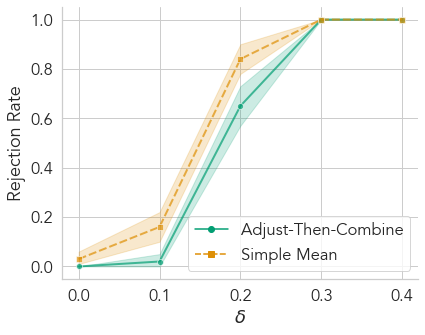

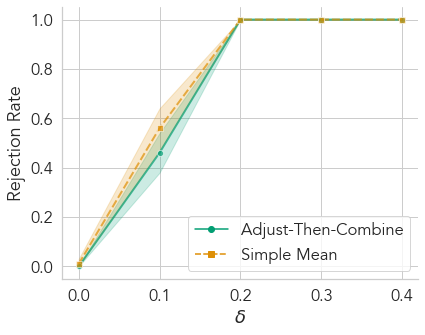

In [15]:
# Power vs. ChangeSize
for alternative in ["Changepoint", "Markovian"]:
    power_change_df = collapsed_df.loc[collapsed_df["Alternative"] == alternative].melt(
        id_vars=["ChangeSize", "RunID"],
        value_vars=["UnadjustedPower", "AdjustedPower"],
        var_name="E-Process", value_name="Power"
    )
    power_change_df["E-Process"] = power_change_df["E-Process"].map(
        {"UnadjustedPower": LABELS["Unadjusted"], "AdjustedPower": LABELS["Adjusted"]})
    fg = sns.relplot(
        x="ChangeSize",
        y="Power",
        hue="E-Process",
        hue_order=LABEL_ORDER,
        palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
        style="E-Process",
        style_order=LABEL_ORDER,
        kind="line",
        markers=["o", "s"],
        errorbar=("ci", 100 * (1 - ALPHA)),
        aspect=1.25,
        height=5,
        linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
        alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
        data=power_change_df,
        facet_kws=dict(legend_out=False),
    )
    # remove legend title and rename items to 'Unadjusted' and 'Adjusted'
    fg._legend.set_title(None)
    fg.ax.set(
        # ylim=(-0.05, 1.05),
        ylabel="Rejection Rate",
        xlabel=r"$\delta$",
    )
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, f"PowerVsChangeSize{alternative}.pdf"), bbox_inches="tight")
    fg.savefig(os.path.join(plots_dir, f"PowerVsChangeSize{alternative}.png"), dpi=350, bbox_inches="tight")

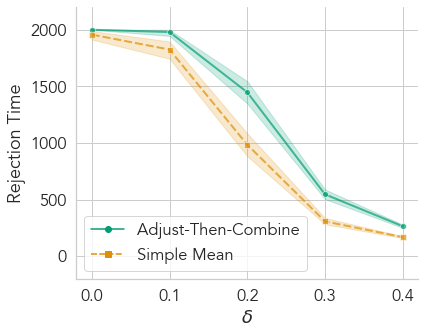

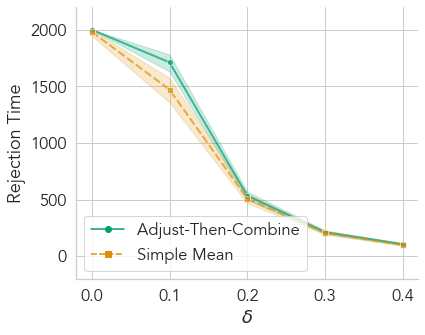

In [16]:
# Rejection Times vs. ChangeSize
for alternative in ["Changepoint", "Markovian"]:
    rejection_time_df = collapsed_df.loc[collapsed_df["Alternative"] == alternative].melt(
        id_vars=["ChangeSize", "RunID"],
        value_vars=["UnadjustedRejectionTime", "AdjustedRejectionTime"],
        var_name="E-Process", value_name="RejectionTime"
    )
    rejection_time_df["E-Process"] = rejection_time_df["E-Process"].map(
        {"UnadjustedRejectionTime": LABELS["Unadjusted"], "AdjustedRejectionTime": LABELS["Adjusted"]})
    fg = sns.relplot(
        x="ChangeSize",
        y="RejectionTime",
        hue="E-Process",
        hue_order=LABEL_ORDER,
        palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
        style="E-Process",
        style_order=LABEL_ORDER,
        kind="line",
        markers=["o", "s"],
        errorbar=("ci", 100 * (1 - ALPHA)),
        aspect=1.25,
        height=5,
        linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
        alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
        data=rejection_time_df,
        facet_kws=dict(legend_out=False),
    )
    fg._legend.set_title(None)
    # bottom left corner
    fg.ax.legend(loc="lower left")
    fg.ax.set(
        ylim=(-200, T+200),
        ylabel="Rejection Time",
        xlabel=r"$\delta$",
    )
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, f"RejectionTimeVsChangeSize{alternative}.pdf"), bbox_inches="tight")
    fg.savefig(os.path.join(plots_dir, f"RejectionTimeVsChangeSize{alternative}.png"), dpi=350, bbox_inches="tight")


In [17]:
cdf = full_df.loc[full_df["Alternative"] == "Changepoint"].groupby(
    by=["ChangeSize", "RunID"],
).agg({"UnadjustedPower": "max", "AdjustedPower": "max"})
cdf.groupby(by="ChangeSize").agg(["mean", "sem"])

UnadjustedPower           AdjustedPower          
                      mean       sem          mean       sem
ChangeSize                                                  
0.0                   0.03  0.017145          0.00  0.000000
0.1                   0.16  0.036845          0.02  0.014071
0.2                   0.84  0.036845          0.65  0.047937
0.3                   1.00  0.000000          1.00  0.000000
0.4                   1.00  0.000000          1.00  0.000000

In [18]:
cdf = full_df.loc[full_df["Alternative"] == "Markovian"].groupby(
    by=["ChangeSize", "RunID"],
).agg({"UnadjustedPower": "max", "AdjustedPower": "max"})
cdf.groupby(by="ChangeSize").agg(["mean", "sem"])

UnadjustedPower           AdjustedPower          
                      mean       sem          mean       sem
ChangeSize                                                  
0.0                   0.01  0.010000          0.00  0.000000
0.1                   0.56  0.049889          0.46  0.050091
0.2                   1.00  0.000000          1.00  0.000000
0.3                   1.00  0.000000          1.00  0.000000
0.4                   1.00  0.000000          1.00  0.000000